# Нормализационный поток

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Генерация данных

In [2]:
import sklearn.datasets

# 2D набор данных
data = sklearn.datasets.make_moons(n_samples=10000, noise=0.1)[0]
X = data.astype("float32")

In [3]:
X[:5]

array([[ 0.7085474 , -0.42768592],
       [-0.05729632,  0.30118427],
       [ 1.667038  , -0.47802517],
       [ 0.87632585,  0.18517481],
       [ 0.9933341 ,  0.31436884]], dtype=float32)

## Визуалиация данных

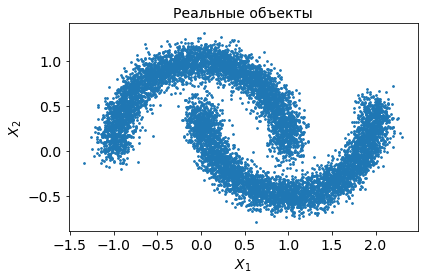

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], s=3, color='C0')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'$X_1$', size=14)
plt.ylabel(r'$X_2$', size=14)
plt.title('Реальные объекты', size=14)
plt.tight_layout()
plt.show()

## Функция Real NVP

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cpu')

In [7]:
class RealNVP(nn.Module):
    def __init__(self, var_size, mask):
        super(RealNVP, self).__init__()

        self.mask = mask

        self.nn_t = nn.Sequential(
            nn.Linear(var_size, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, var_size)
            )
        
        self.nn_s = nn.Sequential(
            nn.Linear(var_size, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, var_size)
            )

    # прямая функция
    def f(self, x):
        t = self.nn_t(x * self.mask[None, :])
        s = torch.tanh(self.nn_s(x * self.mask[None, :]))
 
        # считаем z = f(x)
        z = (x * torch.exp(s) + t) * (1 - self.mask[None, :]) + x * self.mask[None, :]
        
        # считаем Якобиан
        log_det = (s * (1 - self.mask[None, :])).sum(dim=-1)
        return z, log_det

    # обратная функция
    def g(self, z):
        t = self.nn_t(z * self.mask[None, :])
        s = torch.tanh(self.nn_s(z * self.mask[None, :]))
        # считаем x = f^{-1}(z) = g(z)
        x = ((z - t) * torch.exp(-s)) * (1 - self.mask[None, :]) + z * self.mask[None, :]
        return x

## Поток

Соберем несколько Real NVP функций в одну последовательность. Такая последовательность называется потоком.

In [8]:
class NormalizingFlow(nn.Module):
    
    def __init__(self):
        super(NormalizingFlow, self).__init__()
        
        # собираем поток
        layers = []
        for i in range(8):
            mask = torch.tensor([i%2, (i+1)%2], device=DEVICE) # [0, 1] или [1, 0]
            layers.append(RealNVP(var_size=2, mask=mask))
        
        # 2D нормальное распределение
        z_dist = torch.distributions.MultivariateNormal(torch.zeros(2, device=DEVICE), 
                                                        torch.eye(2, device=DEVICE))

        self.layers = nn.ModuleList(layers)
        self.z_dist = z_dist

    # вычисляем функцию потерь
    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, log_det = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = log_likelihood + log_det
            else:
                log_likelihood = log_det
        log_likelihood = log_likelihood + self.z_dist.log_prob(x)

        return log_likelihood.mean()

    
    def generate(self, z):
        # пропускаем шум через поток обратных функций Real NVP
        for layer in self.layers[::-1]:
            z = layer.g(z)
        
        return z

## Обучение

In [9]:
class Fitter(object):
    
    def __init__(self, flow, batch_size=32, n_epochs=10, lr=0.0001, KL_weight=0.001):
        
        self.flow = flow
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr = lr
        
        self.opt  = torch.optim.Adam(self.flow.parameters(), lr=self.lr)
        
        self.flow.to(DEVICE)
    
    
    def fit(self, X):
        
        # переводим данные в тензор
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        # tensor to dataset
        dataset_real = TensorDataset(X_real)
        
        # включаем режим обучения
        self.flow.train(True)
        
        self.loss_history = []

        # цикл обучения
        for epoch in range(self.n_epochs):
            for (x_batch, ) in DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True):
                
                # вычисляем значение функции потерь
                loss = -self.flow.log_prob(x_batch)
                
                # делаем шаг оптимизации
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
                # сохраняем значение функции потерь
                self.loss_history.append(loss.detach().cpu())
                    
        # выключаем режим обучения
        self.flow.train(False)

Теперь обучим нормализацонный поток на наших данных

In [10]:
%%time

flow = NormalizingFlow()

fitter = Fitter(flow, batch_size=64, n_epochs=100, lr=0.0001)
fitter.fit(X)

CPU times: user 2min 58s, sys: 831 ms, total: 2min 59s
Wall time: 3min 1s


Построим кривую обучения

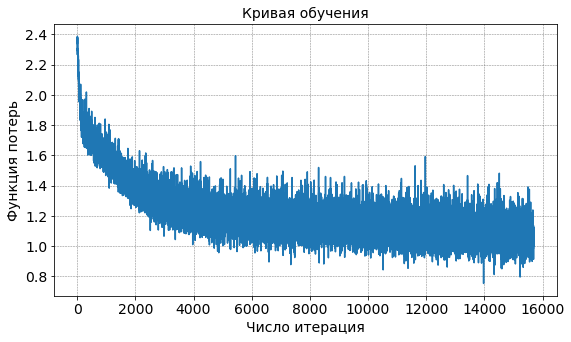

In [11]:
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Число итерация", size=14)
plt.ylabel("Функция потерь", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Кривая обучения", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Генерация новых объектов

Генерируем шум в скрытом пространстве

In [12]:
N = 10000
Z = flow.z_dist.sample((N, ))

С помощью декодировщика переводим шум в новые объекты

In [13]:
X_fake = flow.generate(Z).cpu().detach().numpy()

## Визуализация новых объектов

In [14]:
Z = Z.cpu().detach().numpy()

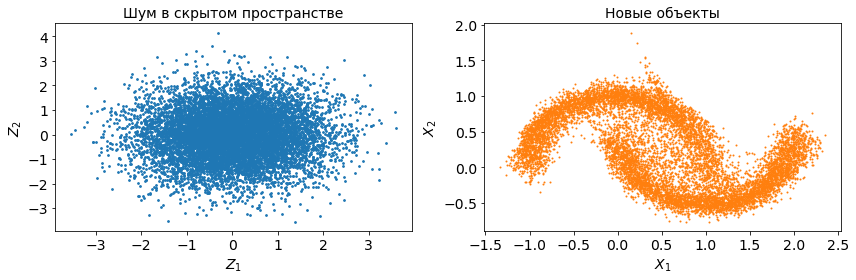

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], s=3, color='C0')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'$Z_1$', size=14)
plt.ylabel(r'$Z_2$', size=14)
plt.title('Шум в скрытом пространстве', size=14)

plt.subplot(1, 2, 2)
plt.scatter(X_fake[:, 0], X_fake[:, 1], s=1, color='C1')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'$X_1$', size=14)
plt.ylabel(r'$X_2$', size=14)
plt.title('Новые объекты', size=14)
plt.tight_layout()
plt.show()